In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import time

from torchvision.datasets import MNIST
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from pgm.data import AlignedSequencesData
from pgm.layers import GaussianLayer, OneHotLayer
from pgm.edge import Edge
from pgm.model import MRF
from pgm.metrics import CD_loss, aa_acc, l1b_reg, msa_mean, ZeroSumGauge

In [3]:
DATA = "/home/cyril/Documents/These/data/PF00397"

aa_letters = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
              'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
aa_ids = {l: i for i, l in enumerate(aa_letters)}

batch_size = 32
q = 21
N = 31

k = 10
lamb_l1b = 0.25
gamma = lamb_l1b/(2*q*N)

## Data

For MNIST

In [8]:
train_dataset = MNIST(f'{DATA}/mnist/', train = True, download=True)
train_loader = DataLoader(train_dataset, batch_size=32,
                                          shuffle=True)

val_dataset = MNIST(f'{DATA}/mnist/', train = False, download=True)
val_loader = DataLoader(val_dataset, batch_size=32,
                                          shuffle=True)

For Proteins

In [4]:
train_dataset = AlignedSequencesData(f"{DATA}/rbm/train.csv")
train_loader = DataLoader(train_dataset, batch_size = batch_size, 
                          shuffle = True, drop_last=True)

val_dataset = AlignedSequencesData(f"{DATA}/rbm/val.csv")
val_loader = DataLoader(val_dataset, batch_size = batch_size, 
                        shuffle = True, drop_last=True)

In [5]:
pots = np.zeros((31, 21))
for w, v in zip(train_dataset.weights,train_dataset.raw_sequences):
    pots += w*v
pots /= np.sum(train_dataset.weights)
pots = pots.T
pots = torch.FloatTensor((pots.T-np.mean(pots, 1)).T).view(-1)

In [7]:
pots.shape

torch.Size([651])

## Edge 

In [6]:
def leaky_relu(): 
    return nn.LeakyReLU(0.2, inplace = False)

class ConvBlock(nn.Module):
    def __init__(self, conv, activation = None, normalization = None, *args, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = conv(*args, **kwargs)
        self.activation, self.normalization = None, None
        if activation is not None:
            self.activation = activation()
        if normalization is not None:
            self.normalization = normalization(args[1])
        
    def forward(self, x):
        h = self.conv(x)
        if self.normalization is not None:
            h = self.normalization(h)
        if self.activation is not None:
            h = self.activation(h)
        return h

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(ResidualBlock, self).__init__()
        self.conv_11 = ConvBlock(nn.Conv1d, leaky_relu, nn.BatchNorm1d, 
                                in_channels, out_channels, 3,
                                stride=1, padding=1, bias=bias)
        self.conv_12 = ConvBlock(nn.Conv1d, leaky_relu, nn.BatchNorm1d, 
                                out_channels, out_channels, 3,
                                stride=2, padding=1, bias=bias)
        self.conv2 = ConvBlock(nn.Conv1d, None, None, 
                                in_channels, out_channels, 3,
                                stride=2, padding=1, bias=bias)

    def forward(self, x):
        identity = x
        out = self.conv_11(x)
        out = self.conv_12(out)
        identity = self.conv2(x)
        out += identity
        return out

In [7]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(ConvNet, self).__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.conv1 = ConvBlock(nn.Conv1d, nn.PReLU, nn.BatchNorm1d, 
                                in_channels, out_channels, 3,
                                stride=1, padding=1, dilation=1)
#         self.conv2 = ConvBlock(nn.Conv1d, nn.PReLU, nn.BatchNorm1d, 
#                                 32, 64, 3,
#                                 stride=1, padding=1, dilation=1)
#         self.conv3 = ConvBlock(nn.Conv1d, nn.PReLU, nn.BatchNorm1d, 
#                                 64, 32, 3,
#                                 stride=1, padding=1, dilation=1)
#         self.conv4 = ConvBlock(nn.Conv1d, nn.PReLU, nn.BatchNorm1d, 
#                                 32, 16, 3,
#                                 stride=1, padding=1, dilation=1)
#         self.conv5 = ConvBlock(nn.Conv1d, None, nn.BatchNorm1d, 
#                         16, out_channels, 1,
#                         stride=1, padding=0, dilation=1)


    def forward(self, x):
        x = x
        h = self.conv1(x)
        return h

In [8]:
def logsumexp(x, dim = -1):
    x = torch.exp(x)
    x = torch.sum(x, dim)
    return (torch.log(x))

class BilinearEdge(Edge):
    def __init__(self, f, g, lay_in, lay_out, gauge = None, weights = None):
        super(BilinearEdge, self).__init__(lay_in, lay_out, gauge, weights)
        self.f, self.g = f, g 
                
    def energy(self, x, h, w = None):
        batch_size = h.size(0)
        x, h = x.detach(), h.detach()
        fx, gh = self.f(x), self.g(h)
        A, B = - logsumexp(fx, 1).sum(-1), - logsumexp(gh, 1).sum(-1)
                
        # Energy
        e = 1/2 * ((h*fx).sum(-1).sum(-1) + A)
        e = 1/2 * ((x*gh).sum(-1).sum(-1) + B)
        
        # MSA mean
        w = (w/w.sum()).detach()
        return (w*e).sum()
    
    def energy(self, x, h, w = None):
        batch_size = h.size(0)
        x, h = x.detach(), h.detach()
        fx, gh = self.f(x), self.g(h)
        A, B = - logsumexp(fx, 1).sum(-1), - logsumexp(gh, 1).sum(-1)
                
        # Energy
        e = 1/2 * ((h*fx).sum(-1).sum(-1) + A)
        e = 1/2 * ((x*gh).sum(-1).sum(-1) + B)
        
        # MSA mean
        w = (w/w.sum()).detach()
        return (w*e).sum()

    def energy_per_neurons(self, x, h):
        batch_size = h.size(0)
        x, h = x.detach(), h.detach()
        fx, gh = self.f(x), h
        A = - logsumexp(fx, 1)
                
        # Energy
        e = (h*fx)
        e -= e.min(1)
        e = e.sum(-1).sum(-1)
        
        return e

    
    def backward(self, h, sample = True):
        p = h
        if sample:
            x = self.in_layer.sample([p])
            return x
        return p
    
    def forward(self, x, sample = True):
        p = self.f(x)
        if sample:
            h = self.out_layer.sample([p])
            return h
        return p
    
    def gibbs_step(self, x, sample = True):
        fx = self.f(x)
        h = fx
        if sample:
            h = self.out_layer.sample([fx]).detach()
        fh = h
        x_rec = gh
        if sample:
            x_rec = self.in_layer.sample([gh])
        return x_rec, h, gh, fx
    
    def save(self, filename):
        torch.save(self, filename)

In [9]:
class DeepMRF(MRF):
    def __init__(self, layers = {}, edges = [], batch_size = 128):
        super(MRF, self).__init__()
        self.layers = layers
        self.edges = {(u,v):BilinearEdge(netu, netv, layers[u], layers[v]) for u,v,netu,netv in edges}
        self.params = nn.ParameterDict({f"{k[0]} -> {k[1]}":next(e.parameters()) for k, e in self.edges.items()})
        self.batch_size = batch_size
        
        self.build_graph()

## Build Model

In [11]:
# import pandas as pd
# DATA = "/home/cyril/Documents/These/data/secondary_structure"
# df = pd.read_json(f"{DATA}/secondary_structure_train.json")

In [17]:
torch.tensor([[0, 0], [1, 1], [2,2]]).view(-1)

tensor([0, 0, 1, 1, 2, 2])

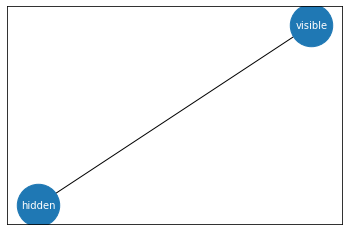

In [10]:
v = OneHotLayer(pots, N = 31, q = 21, name = "visible")
h = GaussianLayer(N = 100, name = "hidden")

E = [(v.name, h.name)]

model = MRF(layers = {v.name: v, 
                    h.name: h},
         edges = E) 

optimizer = optim.Adam(model.parameters(), lr=0.1)
device = torch.device('cpu')

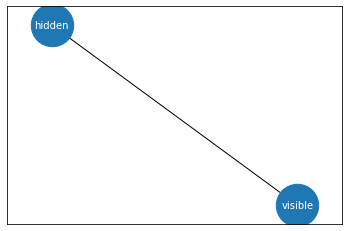

In [11]:
v = OneHotLayer(pots, N = 31, q = 21, name = "visible")
h = OneHotLayer(pots, N = 31, q = 21, name = "hidden")

E = [(v.name, h.name, ConvNet(q, q), ConvNet(q, q))]

model = DeepMRF(layers = {v.name: v, 
                    h.name: h},
         edges = E,
         batch_size = batch_size) 

optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cpu')

In [81]:
def crossentropy(model, d_0, d_f, w):
    losses = []
    for (i,j), edge in model.edges.items():
        _,_, x_rec, h_rec = edge.gibbs_step(d_f[i])
        losses.append(loss_func(x_rec, d_0[i].argmax(1)).sum(-1))
        losses.append(loss_func(h_rec, d_0[j].argmax(1)).sum(-1))
    return sum(losses)

In [ ]:
def crossentropy(model, d_f, w):
    e_f = model.energy(d_f, w)
    losses = []
    for (i,j), edge in model.edges.items():
        _,_, x_rec, h_rec = edge.gibbs_step(d_f[i])
        losses.append(loss_func(x_rec, d_0[i].argmax(1)).sum(-1))
        losses.append(loss_func(h_rec, d_0[j].argmax(1)).sum(-1))
    return sum(losses)

In [82]:
start = time.time()
model.train()
in_lays, out_lays = ["visible", "hidden"], []
edge = model.edges[("visible", "hidden")]

for epoch in range(6000):
    mean_loss, mean_reg, mean_acc = 0, 0, 0
    for batch_idx, data in enumerate(train_loader):
        x = data[0].float().permute(0, 2, 1).to(device)
        w = data[1].float().to(device)
        
        # Sampling
        d_0 = {"visible":x}
        d_0, d_f = model.gibbs_sampling(d_0, in_lays, out_lays, k = 1)
        
        # Optimization
        optimizer.zero_grad()
        cd_loss = crossentropy(model, d_0, d_f, w).mean(-1)
        reg = l1b_reg(model.edges[("visible", "hidden")])
        loss = msa_mean(cd_loss, w)
        acc = aa_acc(d_0["visible"].view(*x.size()), d_f["visible"].view(*x.size()))
        cd_loss.backward()
        optimizer.step()
#         print(d_0["visible"].argmax(-1)[0], d_f["visible"].argmax(-1)[0])
        
        # Metrics
        mean_loss = (mean_loss*batch_idx + loss)/ (batch_idx+1)
        mean_reg = (mean_reg*batch_idx)/(batch_idx+1)
        mean_acc = (mean_acc*batch_idx + acc)/(batch_idx+1)
        m, s = int(time.time()-start)//60, int(time.time()-start)%60
        print(f'''Train Epoch: {epoch} [{int(100*batch_idx/len(train_loader))}%] || Time: {m} min {s} || Loss: {mean_loss:.3f} || Reg: {mean_reg:.3f} || Acc: {mean_acc:.3f}''', end="\r")

        
    print(f'''Train Epoch: {epoch} [100%] || Time: {m} min {s} || Loss: {mean_loss:.3f} || Reg: {mean_reg:.3f} || Acc: {mean_acc:.3f}''', end="\r")
    if not epoch % 5:
        data = next(iter(val_loader))
        x = data[0].float().permute(0, 2, 1).to(device)
        x_f, _, mut, _ = edge.gibbs_step(x, sample=True)
#         print(F.softmax(mut, 1)*21)
        
        acc = aa_acc(x, mut)
        m, s = int(time.time()-start)//60, int(time.time()-start)%60
        print(f'''Val: {epoch} || Time: {m} min {s} || Loss: {mean_loss:.3f} || Reg: {mean_reg:.2f} || Acc: {mean_acc:.3f} ||  Val Acc : {acc:.3f}''')

Val: 0 || Time: 0 min 1 || Loss: 204.074 || Reg: 0.00 || Acc: 0.059 ||  Val Acc : 0.047
Val: 5 || Time: 0 min 11 || Loss: 204.260 || Reg: 0.00 || Acc: 0.060 ||  Val Acc : 0.039
Val: 10 || Time: 0 min 21 || Loss: 204.192 || Reg: 0.00 || Acc: 0.060 ||  Val Acc : 0.044


KeyboardInterrupt: 

## Visualize

In [159]:
import sys

ROOT = "/home/cyril/Documents/These"
sys.path.append(f"{ROOT}/PGM3/source/")
sys.path.append(f"{ROOT}/PGM3/utilities/")

import Proteins_utils, RBM_utils, utilities10 as utilities, sequence_logo, plots_utils

def get_beta(W,include_gaps=False):
    if not include_gaps:
        W_ = W[:,:,:-1]
    else:
        W_ = W
    return  np.sqrt( (W_**2).sum(-1).sum(-1) ).numpy()

ModuleNotFoundError: No module named 'Proteins_utils'

In [368]:
max_acti = model.edges[("visible", "hidden")].get_weights().t().detach().view(31,21, -1).permute(2,0,1)
order = np.argsort(get_beta(max_acti))[::-1]

array([3.421464  , 3.4122577 , 3.2612612 , 3.2488735 , 3.1857338 ,
       3.12147   , 3.043655  , 3.0171416 , 2.9852633 , 2.9537413 ,
       2.8961582 , 2.8769403 , 2.805529  , 2.7740498 , 2.6936152 ,
       2.6857994 , 2.5983324 , 2.5842276 , 2.5811198 , 2.5657399 ,
       2.5656025 , 2.5618253 , 2.5525346 , 2.5494962 , 2.5398147 ,
       2.5252259 , 2.5127726 , 2.5116994 , 2.4920433 , 2.4832978 ,
       2.4704247 , 2.4460647 , 2.438398  , 2.419286  , 2.4112175 ,
       2.3907125 , 2.3836992 , 2.363145  , 2.353229  , 2.3521588 ,
       2.3330472 , 2.2993226 , 2.2935874 , 2.2871013 , 2.273791  ,
       2.2346725 , 2.2283235 , 2.225878  , 2.1795611 , 2.1717482 ,
       2.1644742 , 2.1600082 , 2.1458614 , 2.1353219 , 2.129674  ,
       2.1171308 , 2.104314  , 2.0945017 , 2.085516  , 2.079789  ,
       2.0624979 , 2.0506577 , 2.0453725 , 2.040064  , 2.0395563 ,
       2.000469  , 1.9943125 , 1.9938323 , 1.9866847 , 1.9821129 ,
       1.9801614 , 1.9712776 , 1.9226276 , 1.9177808 , 1.90697

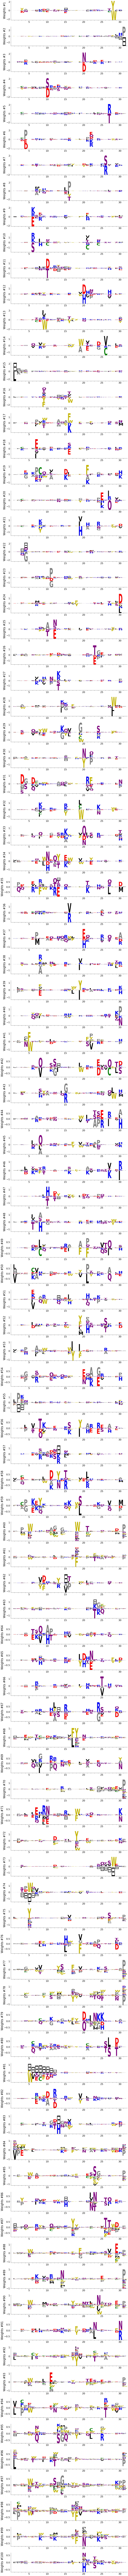

In [369]:
max_acti = model.edges[("visible", "hidden")].get_weights().t().detach().view(31,21, -1).permute(2,0,1)
order = np.argsort(get_beta(max_acti))[::-1]
fig = sequence_logo.Sequence_logo_multiple(max_acti.numpy()[order], figsize=(15,3) ,ticks_every=5,ticks_labels_size=20,title_size=24);